### Additional Features from Microstructural Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Distribution of Order Sizes

Easly 등은 주문 크기당 주문 빈도수를 연구해 유독 반올림된 크기의 거래가 비정상적으로 빈번하다는 사실을 발견했다. 예를 들어서, 거래 빈도는 거래 크기의 함수로 빠르게 감소하는데 반올림된 거래 크기인 $\{5, 10, 20, 25, 50, 100, 200, \dots \}$은 예외였다. Easley 등은 이 현상을 이른바 mouse, 또는 GUI 거래자, 즉 GUI의 버튼을 이용해 주문을 내는 인간 거래자에 기인한다고 했다. 이 경우 E-mini S&P500을 예로 들면 크기 10은 크기 9보다 2.9배, 크기 50은 크기 49에 비해 10.9배, 크기 100은 크기 99에 비해 2.9배, 크기 200은 크기 199보다 27.2배, 크기 250은 크기 249보다 32.5배, 크기 500은 크기 499에 비해 무려 57.1배 더 빈번했다. 이런 패턴은 주로 시장에서의 족적을 감추고자 주로 랜덤화된 거래를 프로그램화하는 silicon trader들의 패턴과는 거리가 멀다.

이 유용한 특성을 사용해 반올림된 크기의 거래 정규 빈도를 확인하고, 기대값으로부터의 편차를 모니터링할 수 있다. Machine Learning Algorithm으로 예를 들어 평소보다 많은 반올림 크기의 거래가 추세와 관련이 있다는 것을 알 수 있다. 왜냐하면, 인간 트레이더들은 투자할 때에는 근본적 견해, 믿음, 확인을 가지고 베팅하는 경향이 있기 때문이다. 이와 반대로 평소보다 반올림 크기의 거래가 줄어들었다면 가격이 횡보할 가능성이 높아진다. 왜냐하면 silicon trader들은 대개 장기적인 관점을 가지고 있지 않기 때문이다.

In [2]:
aapl_order_book = pd.read_parquet('../../Data/aapl_order_book_parquet.parquet')

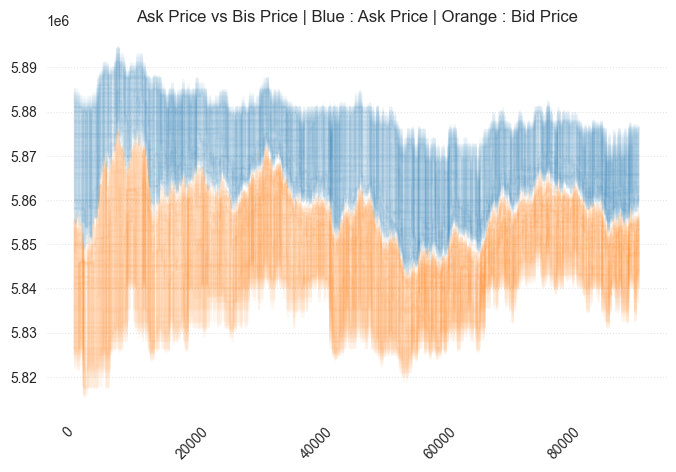

In [3]:
fig, ax = plt.subplots(figsize = (8, 5))
for i in range(1, 51) :
    aapl_order_book[f'ask price {i}'].iloc[1000:].plot(color = 'tab:blue', alpha = 0.05)
for i in range(1, 51) :
    aapl_order_book[f'bid price {i}'].iloc[1000:].plot(color = 'tab:orange', alpha = 0.05)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r'Ask Price vs Bis Price | Blue : Ask Price | Orange : Bid Price')
plt.show()

#### Cancellation Rates, Limit Orders, Market Orders

Eisler(2012) 등은 시장가 주문, 지정가 주문, 호가 취소의 영향을 연구했다. 저자들은 이런 이벤트에 대한 반응에 있어서 소형주와 대형주가 다르다는 것을 발견했다. 이런 크기를 모델링하는 것이 매매 호가 스프레드의 동적 모델링과 연관돼 있다는 결론을 내렸다. 

Easley(2012) 등은 또한 대규모 호가 취소율은 낮은 유동성의 신호일 수 있다고 주장했는데 이는 참여자들이 실행되기 원하지 않은 호가를 제시하고 있기 때문이다. 약탈적 알고리즘의 네 가지 범주를 논한다.

- Quote stuffers : 이들은 latency arbitrage를 한다. 이들의 전략은 오로지 경쟁 알고리즘의 속도를 저하시키려는 의도로 메시지를 통해 거래소를 장악하는 것과 관련된다. 단지 메시지를 발행한 자만이 알기 때문에 무시해도 되는 메시지를 분석해야만 한다.
- Quote danglers : 이 전략은 squeez된 거래자들로 하여금 자신의 이익에 반하는 가격을 추종하도록 하는 호가를 보낸다. Ohara(2011)는 이런 파괴적 행동에 대한 증거를 제시하고 있다.
- Liquidity Squeezer : 큰 손해를 본 대형 투자가들이 현재 포지션을 해제하려 할 때 약탈적 알고리즘은 동일한 방향으로 거래해 유동성을 최대한 없애 버린다. 그 결과 가격은 치솟고 이들은 이익을 보게 된다(Carlin, 2007)
- Pack hunter : 독립적인 약탈자들이 서로의 행동을 알아차리고 연쇄적 효과를 발발시키는 기회를 극대화하고자 무리를 형성한다.(Donefer, 2010, Fabozzi, 2011, Jarrow & Protter, 2011). NANEX(2011)는 pack hunter로 추정되는 무리들이 손절을 강요하는 것을 보여 준다. 비록 이들의 개별적 행동은 너무 소규모여서 감독 당국의 의심을 받지 않지만, 이들의 집합적 행동은 시장을 조종할 수 있다. 이것이 사실이어도 이들은 탈중앙 상태에서 즉흥적으로 협력하기 때문에 담합을 증명하기에는 무척 힘들다.

이런 약찰적 알고리즘은 호가 취소를 비롯한 다양한 주문 형태를 동원해 시장 조성자를 역선택하려 한다. 이들은 거래 기록에 여러 자취를 남기므로, 호가 취호, 지정가 주문, 시장가 주문을 측정하면 의도에 관한 정보가 담긴 유용한 특성의 기초를 얻을 수 있다.

#### Time-Weighted Average Price Execution Algorithms

Easley(2012) 등은 특정 시간 가중 평균 가격 (Time Weighted Average Price)을 목표로 하는 실행 알고리즘의 존재를 인식하는 방법을 설명했다. $\text{TWAP}$ 알고리즘은 대규모 주문을 작은 것으로 분할한 후 일정한 시간 간격으로 제출해 미리 정의된 $\text{TWAP}$를 달성하려는 시도다. 이 저자들은 2010년 11월 7일과 2011년 11월 7일 사이의 E-mini S&P500 futures 거래를 표본으로 선택했다. 이들은 하루를 24시간으로 나누고 각 시간별로 분과 관계 없이 초당 거래량을 덧붙였다. 그런 다음 이 합계된 거래량을 X축은 초당 거래량, Y축은 일중 시점, Z축은 종합된 거래량으로 정의된 공간의 곡면으로 도식화했다. 이 분석은 날짜가 지남에 따른 각 분당 거래량의 분포를 보여주면서, 저빈도 투자자들의 대량 주문 실행을 시간 순서로 시간-공간상에서 찾을 수 있게 해준다. 1분 이내의 최대 밀집 거래량은 대부분 하루 중 매시간의 처음 몇 초 사이에 일어나는 경향이 있다. 이는 특히 0시~1시 GMT (아시아 증권 시장의 장 시작 시간), 5시~9시 (영국과 유럽 증권 시장의 장 시작 시간), 13시~15시 (미국 증권 시장의 장 시작 시간), 20시~21시 (미국 증권 시장의 장 마감 시간)에 그러하다.

유용한 Machine Learning feature는 각 분의 시작 시점에서 주문의 불균형을 평가하고, 일관된 구성 요소가 있는지 결정하는 것이다. 대평 기관 투자가가 낸 $\text{TWAP}$ 주문의 대규모 부분이 대기 중일 때, 이들 대형 기관 투자가를 앞서서 거래하는 데 이용할 수 있다.

In [4]:
import time
import datetime

class TWAPExecutor:
    def __init__(self, total_order_size, num_slices, start_time, end_time):
        self.total_order_size = total_order_size
        self.num_slices = num_slices
        self.start_time = start_time
        self.end_time = end_time
        self.slice_size = self.total_order_size / self.num_slices
        self.interval = (self.end_time - self.start_time).total_seconds() / self.num_slices
        self.executed_orders = []

    def execute_order(self, order_size):
        execution_time = datetime.datetime.now()
        print(f"[{execution_time}] Executed order of size: {order_size}")
        self.executed_orders.append({
            'time': execution_time,
            'size': order_size
        })

    def run(self):
        current_time = datetime.datetime.now()
        print(f"TWAP Execution started at {current_time}")
        for i in range(self.num_slices):
            scheduled_time = self.start_time + datetime.timedelta(seconds=self.interval * i)
            sleep_duration = (scheduled_time - datetime.datetime.now()).total_seconds()
            if sleep_duration > 0:
                time.sleep(sleep_duration)
            self.execute_order(self.slice_size)
        print("TWAP Execution completed.")

#### Option Markets

Muravyev(2013) 등은 주식과 옵션으로부터의 미시 구조적 정보를 사용해 두 시장이 불일치되는 이벤트를 연구했다. 이들은 이런 불일치를 put-call parity 호가에 내재된 기저 매매 호가 스프레드 범위를 도출한 후 실제 주식의 매매 호가 스프레드 범위와 비교함으로써 밝혀 냈다. 이들은 불일치가 주식 호가에 유리하게 해소되는 경향이 있고, 이는 옵션 호가가 경제적으로 주요한 정보를 갖지 않는다는 것을 의미한다는 결론을 내렸다. 이들은 동시에 옵션 거래는 주식 가격에 포함되지 않은 정보를 포함하고 있다는 것을 발견했다. 이런 발견은 주식 옵션을 비롯해 상대적으로 비유동적인 상품을 거래하는 포트폴리오 매니저들에게는 그리 놀라운 일이 아니다. 희소한 가격이 정보적이더라도 호가가 장기간 비합리적으로 남아있을 수 있다.

Cremers and Weinbaum(2010)은 상대적으로 비싼 콜을 가진 주식이 상대적으로 비싼 풋을 가진 주식보다 주당 50bp만큼 더 높은 성과를 낸다는 것을 알아냈다. 이 예측 가능성의 정도는 옵션 유동성이 높고, 주식 유동성이 낮으면 더 커진다.

이 관찰과 일맥상통하는 유용한 특성을 옵션 거래의 풋-콜이 내재된 주가를 계산해 추출할 수 있다. 선물 가격은 미래 가치의 평균이나 기대값만을 나타낸다. 그러나, 옵션 가격은 가격이 산정되고 있는 결과의 전체 분포를 도출할 수 있도록 해준다. Machine Learning Algorithm은 다양한 행사가와 만기에 대해 계산된 여러 가지 지표의 패턴을 찾을 수 있다.

In [5]:
put_call = pd.read_excel('../../Data/put_call_ratio.xlsx', index_col = 0)

In [6]:
import yfinance as yf

aapl_price = yf.download(
    'AAPL',
    start = '2000-01-01',
    end = '2024-09-03',
    progress = False
)

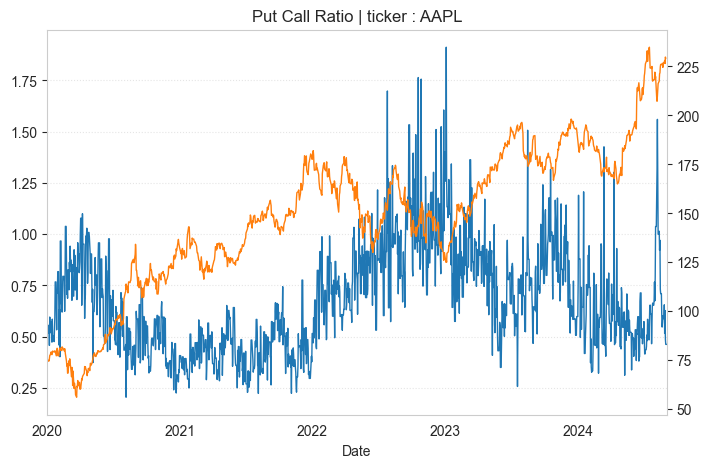

In [7]:
fig, ax = plt.subplots(figsize = (8, 5))

put_call.loc['2020':, 'AAPL'].plot(lw = 1)
aapl_price.loc['2020':, 'Close'].plot(secondary_y = True, lw = 1)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r'Put Call Ratio | ticker : AAPL')
plt.show()

#### Serial Correlation of Signed Order Flow

Toth(2011) 등은 런던 주식 시장 주식의 부호가 있는 주문 흐름을 연구해 주문 부호가 여러 날 동안 양의 자기 상관관계를 가진다는 것을 발견했다. 이들은 이런 관찰을 설명해 줄 수 있는 두 가지 후보를 제시했는데 그것은 바로 herding과 order splitting이다. 이들은 몇 시간 이하의 시간 스케일에서 주문 흐름이 지속적인 것은 order splitting 때문이며, herding 때문이 아니라는 결론을 내렸다.

market microstructure가 주문 흐름 불균형의 지속성을 정보 기반 거래자의 존재 때문으로 설명한다면 부호가 있는 거래량의 계열 상관관계를 통해 이런 지속성의 강도를 측정해 보는 것이 의미가 있다. 이러한 특성은 앞서 알아본 특성들과 보완적인 역할을 할 것이다. 